In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [3]:
df = df_origin[df_origin.Site_Name=='Hermon Stream (Banias)']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [4]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [5]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(489, 8)
(489, 7)


In [6]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [7]:
dfWithoutLastYearVisits.sort_values('Date')
X = dfWithoutLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfWithoutLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [8]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(128,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(8,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [9]:
# # Compiling the model
# model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
# mcp = ModelCheckpoint(filepath='weightsBaniasWithoutLastYearVisits.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

# tb = TensorBoard('logs')

# history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp],validation_split=0.2,batch_size=1)
# clear_output(True)


In [10]:
model.load_weights('weightsBaniasWithoutLastYearVisits.h5')

13/13 [==============================] - 0s 1ms/step

mae 485.96640849784205
rmse 677.2306425458918
std 685.817797847391


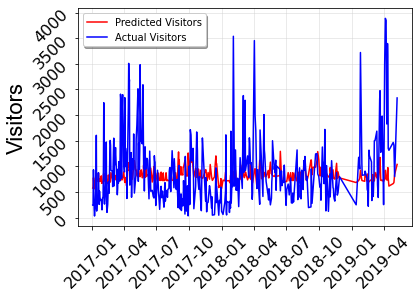

,Prediction,Actual
Date,,
2017-01-04,575.666138,243
2017-01-05,597.957581,247
2017-01-06,777.639587,932
2017-01-08,560.914429,157
2017-01-09,670.858704,30
2017-01-10,707.739258,148
2017-01-11,705.007935,176
2017-01-13,870.579590,638
2017-01-14,838.435303,1606


In [11]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

4/4 [==============================] - 0s 2ms/step

mae 403.05037517936864
rmse 525.208003825447
std 520.0167628773802


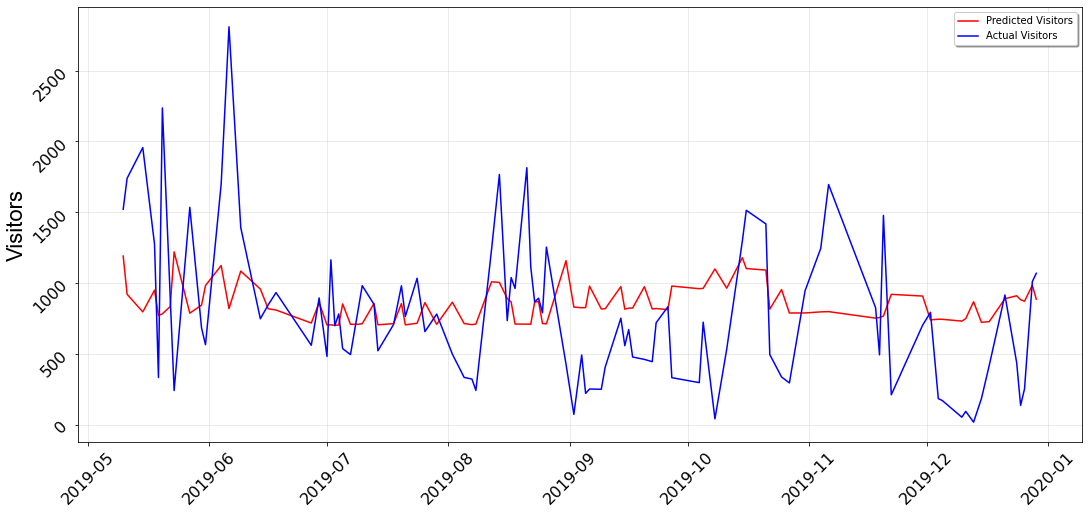

,Prediction,Actual
Date,,
2019-05-10,1190.111084,1520
2019-05-11,919.861572,1739
2019-05-15,795.401978,1956
2019-05-18,949.416870,1273
2019-05-19,770.476929,332
2019-05-20,781.906006,2236
2019-05-22,833.455200,900
2019-05-23,1219.726074,240
2019-05-27,786.582336,1534


In [12]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [13]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(391, 5)
(3,)
(391, 5)
index  10 :: Actual values =  564
index  10 :: Prediction values =  981.4266357421875
157/157 [==============================] - 0s 1ms/step
Intercept 941.7531552569898
Prediction_local [965.65213763]
Right: 981.42664


,0
IsHoliday,290.180620
is weekend,157.751197
IsVacation,-119.741971
Temperature,36.155925
pm10,0.430509


In [14]:
function.getLimeAvg(X_test_scaled=X_test_scaled,X_train_scaled=X_train_scaled,X_train=X_train,model=model)

(391, 5)
(3,)
(391, 5)
157/157 [==============================] - 0s 2ms/step
Intercept 665.3880678640049
Prediction_local [1205.51962922]
Right: 1190.1111
157/157 [==============================] - 0s 2ms/step
Intercept 667.9388496080137
Prediction_local [1200.37815383]
Right: 1190.1111
157/157 [==============================] - 0s 1ms/step
Intercept 668.608546694511
Prediction_local [1201.78283284]
Right: 1190.1111
157/157 [==============================] - 0s 2ms/step
Intercept 666.2657072373886
Prediction_local [1205.2819083]
Right: 1190.1111
157/157 [==============================] - 0s 1ms/step
Intercept 666.242054763854
Prediction_local [1207.06822677]
Right: 1190.1111
157/157 [==============================] - 0s 1ms/step
Intercept 668.51427508146
Prediction_local [1205.86321835]
Right: 1190.1111
157/157 [==============================] - 0s 2ms/step
Intercept 666.266276586203
Prediction_local [1212.25526383]
Right: 1190.1111
157/157 [==============================] - 0s 1ms/st

,0
IsVacation,-119.040524
Temperature,25.428336
is weekend,156.307185
IsHoliday,288.620405
pm10,0.221115
